# Stock Price Prediction 
Here we will focus on analyzing the prices of S&P500, Dow Jones Industrial Average and Gold over the period of 20 years from 01/01/2001 - 12/31/2020. We have built a time series predictive model below. 

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import iplot
import plotly.graph_objs as go
import yfinance as yf
import statsmodels.api as sm
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import coint
import warnings


warnings.filterwarnings("ignore")
plt.style.use('seaborn')

In [39]:
data =[]
#Storing the data imported 
asset_ticker = ['GC=F','^GSPC','DJI','AMT']
#List of Ticker Symbols
asset_names = ['Gold','S&P 500','Dow_Jones Industrial Average','American Tower Corporation']
#List of Names 

for ticker in asset_ticker:
    ft = yf.Ticker(ticker)
    df = ft.history(start='2001-01-01',end='2020-12-30')['Open']
    data.append(df)
#Fetching the Stock prices from Yahoo finance 

price = pd.concat([df for df in data],axis=1)

price.columns = asset_names 
#We will use actual names instead of symbols for column names

price.tail(3)
#Printing the top three rows 

,Gold,S&P 500,Dow_Jones Industrial Average,American Tower Corporation
Date,,,,
2020-12-28,1895.500000,3723.030029,30404.000000,218.869995
2020-12-29,1881.300049,3750.010010,30335.699219,222.210007
2020-12-30,1879.900024,NaN,NaN,NaN


# EXPLORATORY DATA ANALYSIS

In [40]:
#Handaling the Missing Values
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5034 entries, 2001-01-02 to 2020-12-30
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Gold                          4985 non-null   float64
 1   S&P 500                       5030 non-null   float64
 2   Dow_Jones Industrial Average  4867 non-null   float64
 3   American Tower Corporation    5030 non-null   float64
dtypes: float64(4)
memory usage: 196.6 KB


In [41]:
for column in price.columns:
    null_dt = price[price[column].isnull()].index 
    # find out date where it is null
    idx = np.searchsorted(price.index, null_dt)
    for i in range(len(idx)-1):
        if math.isnan(price.iloc[idx[i]+1][column]): 
            # if value afterwards is NaN, then average will also be NaN
            price[column].loc[null_dt[i]] = price.iloc[idx[i]-1][column] 
        elif math.isnan(price.iloc[idx[i]-1][column]):
            price[column].loc[null_dt[i]] = price.iloc[idx[i]+1][column] 
            # if value before is NaN, then average will also be NaN
        else:
            avg = (price.iloc[idx[i]+1][column] + price.iloc[idx[i]-1][column])/2
            price[column].loc[null_dt[i]] = avg

In [42]:
yearly_price_open = price.resample('1Y').first()
yearly_price_close = price.resample('1Y').last()
yearly_price_high = price.resample('1Y').max()
yearly_price_low = price.resample('1Y').min()

#Using Open High Low Close Chart for analysis
for column in price.columns:
    fig = (go.Figure(data=go.Ohlc(
                                    x=yearly_price_open[column].index.year,
                                    open=yearly_price_open[column],
                                    high=yearly_price_high[column],
                                    low=yearly_price_low[column],
                                    close=yearly_price_close[column])))
    fig.update_layout(title_text=column,
                  title={
                    'y':0.85,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},)
    fig.show()

In [43]:
#Exploring yearly rates 
def percent(df): 
    # function for transforming float DataFrame to DataFrame with percentages
    for column in df.columns:
        df[column] = df[column].apply(lambda x: "{:.2%}".format(x))
    return df

yearly_rates = (yearly_price_close - yearly_price_open)/yearly_price_open
yearly_rates_p = percent(yearly_rates.copy())
yearly_rates_p.index = yearly_price_open.index.year
yearly_rates_p.tail(15)

,Gold,S&P 500,Dow_Jones Industrial Average,American Tower Corporation
Date,,,,
2006,22.48%,14.13%,14.90%,35.31%
2007,32.75%,3.79%,6.38%,13.82%
2008,3.66%,-39.33%,-32.72%,-33.63%
2009,24.24%,24.76%,15.42%,44.69%
2010,25.77%,12.56%,9.39%,18.37%
2011,9.45%,0.41%,4.69%,17.94%
2012,5.51%,11.40%,5.70%,27.17%
2013,-28.48%,29.20%,23.59%,3.46%
2014,-0.42%,12.80%,8.40%,28.44%


In [44]:
percent(yearly_rates.describe().drop('count'))

,Gold,S&P 500,Dow_Jones Industrial Average,American Tower Corporation
mean,10.82%,7.08%,5.60%,21.71%
std,14.56%,17.49%,13.91%,54.07%
min,-28.48%,-39.33%,-32.72%,-75.31%
25%,3.53%,0.33%,-0.66%,2.77%
50%,10.74%,10.94%,7.39%,18.15%
75%,22.66%,16.54%,14.98%,38.79%
max,32.75%,29.80%,24.33%,192.01%


In [46]:
#Exploring Intercorrelations and Distribution of weekly prices 
# print(price)
weekly_price = price.asfreq('W', method='ffill')
# Ommitting Nan values and fetching the weekly value of last day
# print(weekly_price)
weekly_rates = ((weekly_price - weekly_price.shift(1))/weekly_price.shift(1)).iloc[1::,:]
#Obtaining the weekly rates 

<AxesSubplot:>

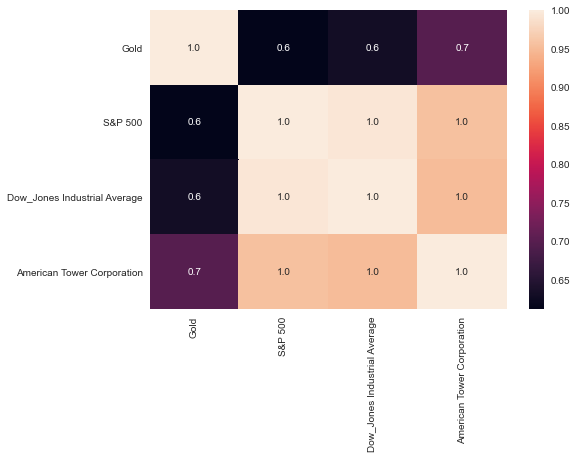

In [47]:
sns.heatmap(weekly_price.corr(), annot=True,linecolor="red",fmt= '.1f')

Almost perfect linear correlation is present between S&P500 and DJIA, but gold shows low values.

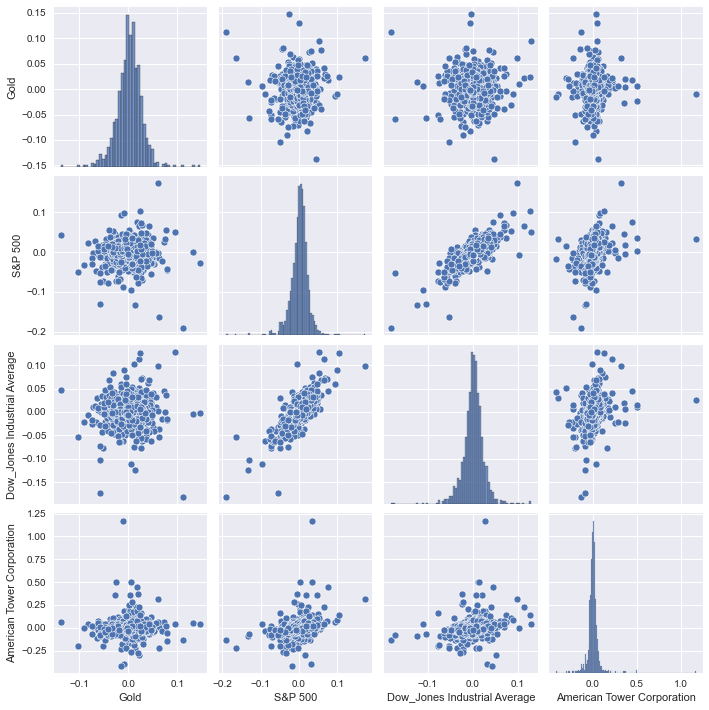

In [48]:
sns.pairplot(weekly_rates)

We can observe a same situation in the Covariance matrix.

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

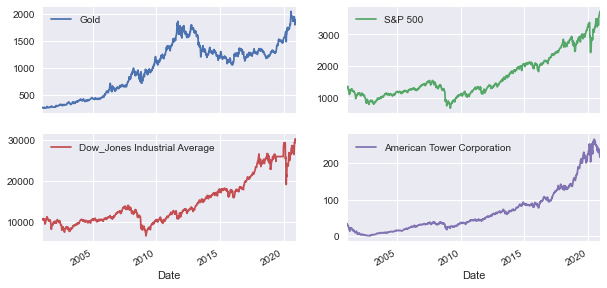

In [49]:
# Before getting into the modeling part, let us check stationarity for both prices and rates of the corresponding assets.
weekly_price.plot(subplots=True, layout=(4,2),figsize=(10,10))

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

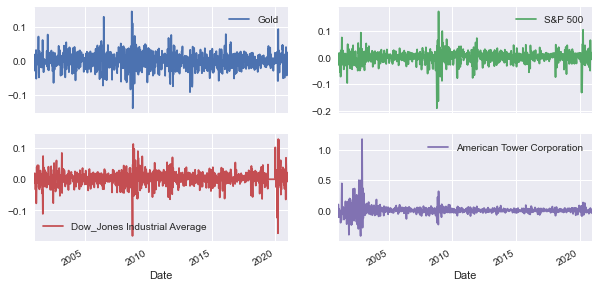

In [50]:
weekly_rates.plot(subplots=True, layout=(4,2), figsize=(10,10))

It is obvious from the graph that prices show the presence of the upward trend, while rates indicate high possibility for stationarity. Since for the modeling part we need stationary data, I'll test the stationarity of the first difference data.

In [51]:
#Performing AD Fuller Test
def Stationarity(data, alpha=0.05):
    adf = pd.DataFrame(columns = ['test','p'])
    for col in data.columns:
        df = adfuller(data[col], autolag='AIC')
        adf = pd.concat([adf, pd.DataFrame(np.array(df[0:2]).reshape(1,2),columns = ['test','p'])],axis=0)
    adf['Stationary'] = adf['p'] < alpha 
    # significance level
    adf.index = data.columns
    return adf
# test statistic is lower than the critical value shown, you reject the null hypothesis and 
# infer that the time series is stationary.    
weekly_price_d = weekly_price.diff().dropna()

Stationarity(weekly_price_d)


,test,p,Stationary
Gold,-33.306521,0.000000e+00,True
S&P 500,-16.702737,1.456599e-29,True
Dow_Jones Industrial Average,-11.614888,2.462498e-21,True
American Tower Corporation,-5.061175,1.677066e-05,True


# ARIMA MODEL GOLD

As the procedure is the same with all our variables, I've decided to showcase the steps only for gold and the analog approach can be transferred to S&P500 and DJIA.

## Order Selection

The first step is selecting the appropriate order of the ARIMA model; more accurately, we need to find how many past values (p) and moving averages (q) should be included in the model. Please note that I'm using the first difference of the dataset, so basically, the d parameter is equal to 1.

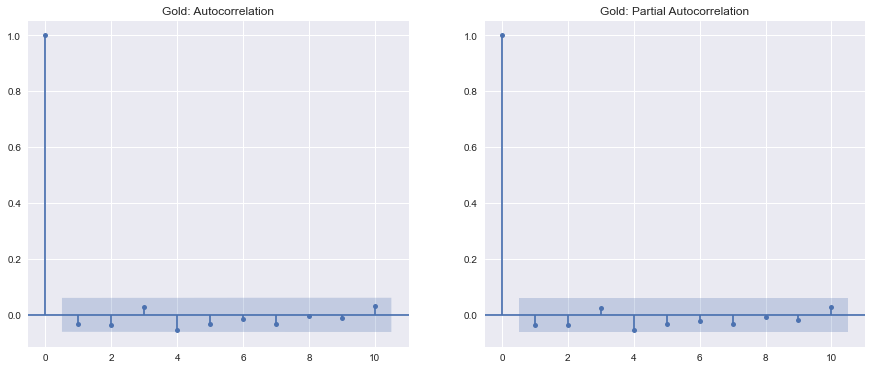

In [72]:
fig, axs = plt.subplots(1,2, figsize =(15,6))


plot_acf(weekly_price_d['Gold'], lags=10, ax=axs[0], title='Gold'+': Autocorrelation')
plt.close(2)
plot_pacf(weekly_price_d['Gold'], lags=10, ax=axs[1], title='Gold'+': Partial Autocorrelation')
plt.close(2)

Once we determine the nature of the auto-correlations we use the following rules of thumb.

Rule 1: If the ACF shows exponential decay, the PACF has a spike at lag 1, and no correlation for other lags, then use one autoregressive (p)parameter

Rule 2: If the ACF shows a sine-wave shape pattern or a set of exponential decays, the PACF has spikes at lags 1 and 2, and no correlation for other lags, the use two autoregressive (p) parameters

Rule 3: If the ACF has a spike at lag 1, no correlation for other lags, and the PACF damps out exponentially, then use one moving average (q) parameter.

Rule 4: If the ACF has spikes at lags 1 and 2, no correlation for other lags, and the PACF has a sine-wave shape pattern or a set of exponential decays, then use two moving average (q) parameter.

Rule 5: If the ACF shows exponential decay starting at lag 1, and the PACF shows exponential decay starting at lag 1, then use one autoregressive (p) and one moving average (q) parameter

For order selection, ACF and PACF graphs were used and the value for both p and q is two, which means I'll use ARIMA(2,1,2) model for the actual dataset or ARIMA(2,0,2) for the first difference.

In [73]:
test_size = 40
train_arima, test_arima = weekly_price_d['Gold'][:-test_size], weekly_price_d['Gold'][-test_size:]
model_arima = ARIMA(train_arima, order=(2,0,2)) 
# d component is 0, so this would actually call ARMA model
model_arima_fitted = model_arima.fit()
model_arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 1001
Model:                     ARMA(2, 2)   Log Likelihood               -4657.566
Method:                       css-mle   S.D. of innovations             25.380
Date:                Wed, 03 Feb 2021   AIC                           9327.131
Time:                        19:15:00   BIC                           9356.584
Sample:                    01-14-2001   HQIC                          9338.325
                         - 03-15-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3091      0.677      1.933      0.053      -0.018       2.637
ar.L1.Gold     0.0385      0.183      0.210      0.834      -0.321       0.398
ar.L2.Gold     0.5699      0.164      3.473      0.001       0.248       0.892
ma.L1.Gold    -0.0309      0.171     -0.181      0.857      -0.366       0.304
ma.L2.Gold    -0.6388      0.153     -4.185      0.000      -0.938      -0.340
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2913           +0.0000j            1.2913            0.0000
AR.2           -1.3589           +0.0000j            1.3589            0.5000
MA.1            1.2272           +0.0000j            1.2272            0.0000
MA.2           -1.2756           +0.0000j            1.2756            0.5000
-----------------------------------------------------------------------------
"""

# Forecasting:

In [74]:
forecast_arima = model_arima_fitted.forecast(steps=test_size)[0]
df_forecast_arima = pd.DataFrame(forecast_arima, index=weekly_price_d.index[-test_size:], columns=['Gold'] )

print('Error:',np.sqrt(mean_squared_error(test_arima, df_forecast_arima)))

Error: 50.36123722633037


In [75]:
#Lets lower the error by scaling 

error = []
for scaler in (MinMaxScaler(), StandardScaler()): # will use stnadard scaler and minMax sclaer
    train_arima_scaled = scaler.fit_transform(train_arima.values.reshape(-1,1))

    model_arima_scaled = ARIMA(train_arima_scaled, order=(2,0,2))
    model_arima_scaled_fitted = model_arima_scaled.fit()
    forecast_arima_scaled = model_arima_scaled_fitted.forecast(steps=test_size)[0]
    forecast_arima_reverse = scaler.inverse_transform(forecast_arima_scaled.reshape(-1,1))

    df_forecast_arima = pd.DataFrame(forecast_arima_reverse, index=weekly_price_d.index[-test_size:], columns=['Gold'])
    error.append(np.sqrt(mean_squared_error(test_arima, df_forecast_arima)))

pd.DataFrame(error, index = ['MinMaxScaler', 'StandardScaler'], columns = ['Error'])

,Error
MinMaxScaler,50.361238
StandardScaler,50.361237


Error is almost the same so there is no point of scaling the data.

In [77]:
model_arima = ARIMA(weekly_price_d['Gold'], order=(2,0,2)) 
model_arima_fitted = model_arima.fit()
model_arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Gold   No. Observations:                 1041
Model:                     ARMA(2, 2)   Log Likelihood               -4900.903
Method:                       css-mle   S.D. of innovations             26.814
Date:                Wed, 03 Feb 2021   AIC                           9813.806
Time:                        19:15:35   BIC                           9843.493
Sample:                    01-14-2001   HQIC                          9825.067
                         - 12-20-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5514      0.696      2.228      0.026       0.187       2.916
ar.L1.Gold    -0.1952      0.159     -1.230      0.219      -0.506       0.116
ar.L2.Gold     0.6892      0.152      4.523      0.000       0.391       0.988
ma.L1.Gold     0.1691      0.146      1.157      0.247      -0.117       0.456
ma.L2.Gold    -0.7456      0.141     -5.291      0.000      -1.022      -0.469
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0712           +0.0000j            1.0712            0.5000
AR.2            1.3544           +0.0000j            1.3544            0.0000
MA.1           -1.0503           +0.0000j            1.0503            0.5000
MA.2            1.2771           +0.0000j            1.2771            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='Date'>

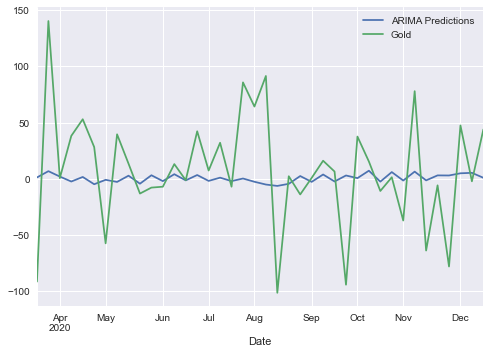

In [78]:
start=len(train_arima)
end=len(train_arima)+len(test_arima)-1
pred=model_arima_fitted.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test_arima.plot(legend=True)

In [80]:
forecast_arima = model_arima_fitted.forecast(steps=test_size)[0]
df_forecast_arima = pd.DataFrame(forecast_arima, index=weekly_price_d.index[-test_size:], columns=['Gold'] )

print('Error:',np.sqrt(mean_squared_error(test_arima, df_forecast_arima)))

Error: 51.26781507162938


In [87]:
def inverse_diff(df, df_forecast):
    last_row = df.iloc[-1,:]
    l = []
    num_forecast = df_forecast.shape[0]
    for row in range(num_forecast):
        arr = np.array(last_row + df_forecast.iloc[row,:])
        l.append(arr)
        last_row = arr
    time = pd.date_range((df.index[-1]+timedelta(weeks=1)).date(), num_forecast, freq='W')
    result = pd.DataFrame(data=l, columns=df.columns, index=df_forecast.index+timedelta(weeks=4))
    return result

In [89]:
model_arima = ARIMA(weekly_price_d['Gold'], order=(2,0,2)) 
model_arima_fitted = model_arima.fit()
prediction_size = 4 # next month
forecast_arima = model_arima_fitted.forecast(steps=prediction_size)[0]
df_forecast_arima = pd.DataFrame(forecast_arima, index=weekly_price_d.index[-prediction_size:], columns=['Gold'] )
weekly_price_forecast_arima = inverse_diff(pd.DataFrame(weekly_price['Gold']), df_forecast_arima)
weekly_price_forecast_arima.head()

,Gold
Date,
2020-12-27,NaN
2021-01-03,NaN
2021-01-10,NaN
2021-01-17,NaN


# ARIMA MODEL AMT 

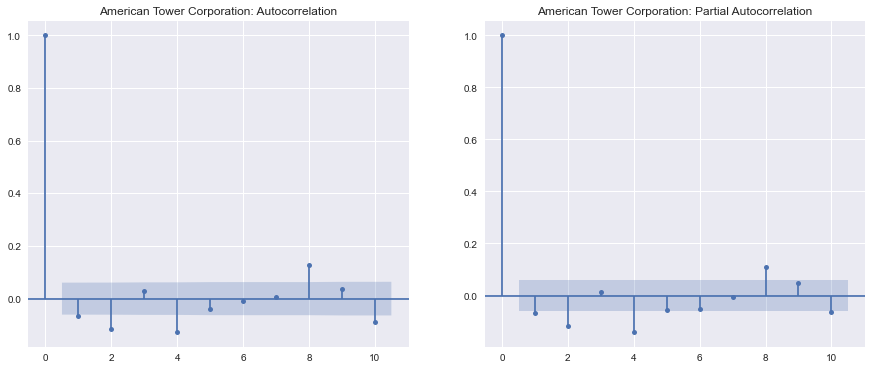

In [83]:
fig, axs = plt.subplots(1,2, figsize =(15,6))


plot_acf(weekly_price_d['American Tower Corporation'], lags=10, ax=axs[0], title='American Tower Corporation'+': Autocorrelation')
plt.close(2)
plot_pacf(weekly_price_d['American Tower Corporation'], lags=10, ax=axs[1], title='American Tower Corporation'+': Partial Autocorrelation')
plt.close(2)

In [84]:
test_size = 40
train_arima, test_arima = weekly_price_d['American Tower Corporation'][:-test_size], weekly_price_d['American Tower Corporation'][-test_size:]
model_arima = ARIMA(train_arima, order=(2,0,2)) # d component is 0, so this would actually call ARMA model
model_arima_fitted = model_arima.fit()
model_arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                  
======================================================================================
Dep. Variable:     American Tower Corporation   No. Observations:                 1001
Model:                             ARMA(2, 2)   Log Likelihood               -2303.069
Method:                               css-mle   S.D. of innovations              2.415
Date:                        Wed, 03 Feb 2021   AIC                           4618.137
Time:                                19:18:09   BIC                           4647.590
Sample:                            01-14-2001   HQIC                          4629.331
                                 - 03-15-2020                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.1890      0.068      2.779      0.005       0.056       0.322
ar.L1.American Tower Corporation     0.1034      0.160      0.647      0.518      -0.210       0.417
ar.L2.American Tower Corporation    -0.6280      0.105     -5.999      0.000      -0.833      -0.423
ma.L1.American Tower Corporation    -0.2756      0.167     -1.652      0.099      -0.603       0.051
ma.L2.American Tower Corporation     0.6335      0.088      7.222      0.000       0.462       0.805
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0823           -1.2592j            1.2619           -0.2396
AR.2            0.0823           +1.2592j            1.2619            0.2396
MA.1            0.2175           -1.2374j            1.2564           -0.2223
MA.2            0.2175           +1.2374j            1.2564            0.2223
-----------------------------------------------------------------------------
"""

In [85]:
forecast_arima = model_arima_fitted.forecast(steps=test_size)[0]
df_forecast_arima = pd.DataFrame(forecast_arima, index=weekly_price_d.index[-test_size:], columns=['American Tower Corporation'] )

print('Error:',np.sqrt(mean_squared_error(test_arima, df_forecast_arima)))

Error: 9.466965844961754


In [88]:
model_arima = ARIMA(weekly_price_d['American Tower Corporation'], order=(2,0,2)) 
model_arima_fitted = model_arima.fit()
prediction_size = 4 # next month
forecast_arima = model_arima_fitted.forecast(steps=prediction_size)[0]
df_forecast_arima = pd.DataFrame(forecast_arima, index=weekly_price_d.index[-prediction_size:], columns=['American Tower Corporation'] )
weekly_price_forecast_arima = inverse_diff(pd.DataFrame(weekly_price['American Tower Corporation']), df_forecast_arima)
weekly_price_forecast_arima.head()

,American Tower Corporation
Date,
2020-12-27,218.600916
2021-01-03,218.591619
2021-01-10,219.799925
2021-01-17,219.604816


<AxesSubplot:xlabel='Date'>

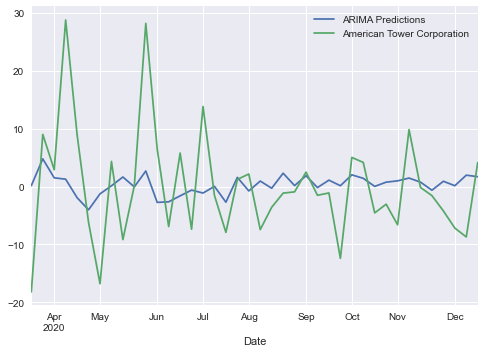

In [68]:
start=len(train_arima)
end=len(train_arima)+len(test_arima)-1
pred=model_arima_fitted.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test_arima.plot(legend=True)